In [86]:
import sys
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import patches

import cv2
import torch
import torchvision
from torch import nn
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from torch.utils import data as torch_data
from torchvision import transforms as T
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from xml.etree import ElementTree as ET

In [99]:
CFG = {
    'n_epochs': 10,
    'lr': 0.0001,
    'batch_size': 10,
    'num_classes': 4,
    'momentum': 0.9,
}

DATA

In [88]:
images = 'face-mask-detection/images/'
annotations = 'face-mask-detection/annotations/'

In [89]:
class MaskDataset(torch.utils.data.Dataset):
    def __init__(self, images, annotations, width, height, T=None):
        self.T = T
        self.images = images
        self.annotations = annotations
        self.width = width
        self.height = height


        self.imgs = [image for image in sorted(os.listdir(images))]
        self.annotate = [image for image in sorted(os.listdir(annotations))]

        self.classes = [_, 'with_mask', 'without_mask', 'mask_weared_incorrect']


    def __len__(self):
        return len(self.imgs)


    def __getitem__(self, index):
        image_name = self.imgs[index]
        image_path = os.path.join(self.images, image_name)

        # reading and converting the images
        img = cv2.imread(image_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
        img_size = cv2.resize(img_rgb, (self.width, self.height), cv2.INTER_AREA)

        img_size /= 255.0

        # annotation file
        annotation_filename = self.annotate[index]
        annotation_path = os.path.join(self.annotations, annotation_filename)

        boxes = []
        labels = []
        tree = ET.parse(annotation_path)
        root = tree.getroot()


        # opencv size as width and height
        wt = img.shape[1]
        ht = img.shape[0]

        for member in root.findall('object'):
            labels.append(self.classes.index(member.find('name').text))

            xmin = int(member.find('bndbox').find('xmin').text)
            xmax = int(member.find('bndbox').find('xmax').text)
            ymin = int(member.find('bndbox').find('ymin').text)
            ymax = int(member.find('bndbox').find('ymax').text)

            # corrected box coordinates for image size
            xmin_cor = (xmin / wt) * self.width
            xmax_cor = (xmax / wt) * self.width
            ymin_cor = (ymin / ht) * self.height
            ymax_cor = (ymax / ht) * self.height

            boxes.append([xmin_cor, ymin_cor, xmax_cor, ymax_cor])

            # convert into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)

        area = (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1])

        # for not a crowd
        iscrowd = torch.zeros((boxes.shape[0], ), dtype=torch.long)

        labels = torch.as_tensor(labels, dtype=torch.long)


        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['area'] = area
        target['iscrowd'] = iscrowd

        image_id = torch.tensor([index])
        target['image_id'] = image_id

        if self.T:

            sample = self.T(
                image = img_size,
                bboxes = target['boxes'],
                labels = labels
            )

            img_size = sample['image']
            target['boxes'] = torch.Tensor(sample['bboxes'])

        return img_size, target


# check dataset
dataset = MaskDataset(images, annotations, 224, 224)
print('Length of dataset:', len(dataset), '\n')

# getting the image and target for a test index
img, target = dataset[15]
print('Image shape:', img.shape, '\n', 'Target:', target)

Length of dataset: 853 

Image shape: (224, 224, 3) 
 Target: {'boxes': tensor([[  9.5200, 152.1194,  19.6000, 168.8358],
        [  9.5200,  84.4179,  14.0000,  96.9552],
        [ 26.8800,  81.9104,  34.1600,  94.4478],
        [  9.5200, 106.1493,  15.1200, 120.3582],
        [  2.8000, 111.1642,   7.8400, 127.0448],
        [ 61.0400,  49.3134,  73.9200,  68.5373],
        [ 78.4000,  53.4925,  90.1600,  71.0448],
        [103.0400,  56.8358, 115.9200,  77.7313],
        [138.8800,  61.0149, 149.5200,  79.4030],
        [162.9600,  54.3284, 175.8400,  75.2239],
        [214.4800,  80.2388, 222.3200,  91.9403],
        [214.4800, 104.4776, 222.8800, 121.1940]]), 'labels': tensor([1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 2]), 'area': tensor([168.5015,  56.1672,  91.2717,  79.5701,  80.0382, 247.6035, 206.4144,
        269.1343, 195.6489, 269.1341,  91.7398, 140.4180]), 'iscrowd': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'image_id': tensor([15])}


Visualize the image and it's bounding boxes

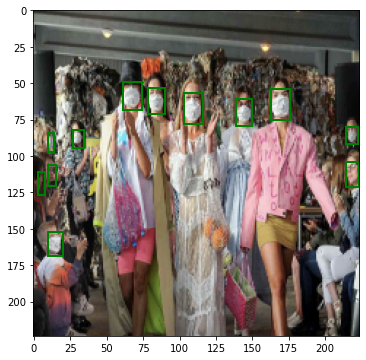

In [90]:
def plot_bbox(img, target):
    fig, ax = plt.subplots(1, 1)
    fig.set_size_inches(12, 6)
    ax.imshow(img)
    for box in (target['boxes']):
        x, y, width, height = box[0], box[1], box[2] - box[0], box[3] - box[1]
        mpatch = patches.Rectangle(
            (x, y),
            width, height,
            lw = 2,
            edgecolor = 'green',
            facecolor = 'none'
        )

        ax.add_patch(mpatch)
    plt.show()

# plotting the image with bounding boxes
img, target = dataset[15]
plot_bbox(img, target)

Define an augmentation 

In [109]:
def get_transform(train):

    if train:
        return A.Compose(
            [
               # A.HorizontalFlip(0.5),
                ToTensorV2(p=1.0)
            ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']}
        )
    else:
        return A.Compose(
            [
                ToTensorV2(p=1.0)
            ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']}
        )

In [110]:
def collate_func(batch):
    return tuple(zip(*batch))

Dataset and Dataloader

In [93]:
dataset = MaskDataset(
    images,
    annotations,
    480, 480,
    T = get_transform(train=True)
)

test_data = MaskDataset(
    images,
    annotations,
    480, 480,
    T = get_transform(train=False)
)

# split data into train and test set
torch.manual_seed(2)
indices = torch.randperm(len(dataset)).tolist()

# train and test split
test_size = int(len(dataset) * 0.3)
dataset = torch_data.Subset(dataset, indices[:-test_size])
test_data = torch_data.Subset(test_data, indices[-test_size:])

In [112]:
train_dataloader = torch_data.DataLoader(
    dataset,
    batch_size=CFG['batch_size'],
    shuffle=True,
    num_workers=4,
    collate_fn=collate_func,
)
test_dataloader = torch_data.DataLoader(
    test_data,
    batch_size=CFG['batch_size'],
    shuffle=False,
    num_workers=4,
    collate_fn=collate_func,
)

MODEL

In [95]:
class Model(torch.nn.Module):
    def __init__(self):
        super(Model, self).__init__()

        self.model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
        # number of input features
        in_features = self.model.roi_heads.box_predictor.cls_score.in_features
        # replace the pretrained with a new one
        self.model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    def forward(self, x):
        out = self.model(x)
        return out

In [105]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
num_classes = CFG['num_classes'] # 4 classes, considering background as a class too

In [104]:
model = Model().to(device)
print(model)

Model(
  (model): FasterRCNN(
    (transform): GeneralizedRCNNTransform(
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        Resize(min_size=(800,), max_size=1333, mode='bilinear')
    )
    (backbone): BackboneWithFPN(
      (body): IntermediateLayerGetter(
        (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (bn1): FrozenBatchNorm2d(64, eps=0.0)
        (relu): ReLU(inplace=True)
        (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (layer1): Sequential(
          (0): Bottleneck(
            (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn1): FrozenBatchNorm2d(64, eps=0.0)
            (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn2): FrozenBatchNorm2d(64, eps=0.0)
            (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn3): F

TRAIN

In [106]:
optimizer = torch.optim.SGD(model.parameters(), lr=CFG['lr'], momentum=CFG['momentum'])
criterion = F.cross_entropy

In [114]:
history = {}

for epoch in range(CFG['n_epochs']):
    print(f'Epoch: {epoch}')

    model.train()
    i = 0
    running_loss = 0.0
    train_loss = []
    for Images, Annotations in train_dataloader:
        i += 1
        Images = list(img.to(device) for img in Images)
        Annotations = [{n: v.to(device) for n, v in k.items()} for k in Annotations]
        loss_dict = model(Images, Annotations)
        losses = sum(loss for loss in loss_dict.values())
        
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        running_loss += losses.item()

Epoch: 0


PicklingError: Can't pickle <class '__main__.Model'>: it's not the same object as __main__.Model